In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, diffx_tv, diffx_uq, diffy_vq, diffy_tu, filter_apply, filter_iteration, compute_isotropic_KE
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/random-sampled', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky', additional_subfolder='output')

Error, cannot find files in folder/scratch/pp2681/mom6/Apr2022/generalization/R2_EXP205-repeat/output
Error, cannot find files in folder/scratch/pp2681/mom6/Apr2022/generalization/R4_ZB-repeat/output


In [45]:
ds.exps

['R16',
 'R2',
 'R32',
 'R4',
 'R64',
 'R8',
 'R10_EXP205',
 'R10_momf',
 'R10_ref',
 'R12_EXP205',
 'R12_momf',
 'R12_ref',
 'R2_EXP205',
 'R2_EXP205-repeat',
 'R2_ZB',
 'R2_ZB-ssd',
 'R2_momf',
 'R2_ref',
 'R3_EXP205',
 'R3_ZB',
 'R3_ZB-ssd',
 'R3_momf',
 'R3_ref',
 'R4_EXP205',
 'R4_ZB',
 'R4_ZB-ssd',
 'R4_momf',
 'R4_ref',
 'R6_EXP205',
 'R6_ZB',
 'R6_ZB-ssd',
 'R6_momf',
 'R6_ref',
 'R8_EXP205',
 'R8_ZB',
 'R8_ZB-ssd',
 'R8_momf',
 'R8_ref',
 'R64_R2_ref',
 'R64_R3_ref',
 'R64_R4_ref',
 'R64_R6_ref',
 'R64_R8_ref',
 'R64_R10_ref',
 'R64_R12_ref']

In [3]:
for exp in ['R2_ref', 'R3_ref', 'R4_ref', 'R6_ref', 'R8_ref']:
    ds.remesh('R64',exp)

Experiment R64 coarsegrained to R2_ref is created. Its identificator=R64_R2_ref
Experiment R64 coarsegrained to R3_ref is created. Its identificator=R64_R3_ref
Experiment R64 coarsegrained to R4_ref is created. Its identificator=R64_R4_ref
Experiment R64 coarsegrained to R6_ref is created. Its identificator=R64_R6_ref
Experiment R64 coarsegrained to R8_ref is created. Its identificator=R64_R8_ref


In [4]:
ds.remesh('R64','R4')

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4


In [8]:
def error_ssh(exps):
    bare = np.zeros(len(exps))
    ZB = np.zeros(len(exps))
    ZB_ssd = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    
    def coarse(x):
        return remesh(x,ds['R2_ref'].h)
    def Lk(x,y):
        return Lk_error(coarse(x),coarse(y),False)[0]
    for j,exp in enumerate(exps):
        bare[j] = Lk(ds[exp+'_ref'].ssh_mean,ds[f'R64_{exp}_ref'].ssh_mean)
        ZB[j] = Lk(ds[exp+'_ZB'].ssh_mean,ds[f'R64_{exp}_ref'].ssh_mean)
        ZB_ssd[j] = Lk(ds[exp+'_ZB-ssd'].ssh_mean,ds[f'R64_{exp}_ref'].ssh_mean)
        exp205[j] = Lk(ds[exp+'_EXP205'].ssh_mean, ds[f'R64_{exp}_ref'].ssh_mean)
        mom[j] = Lk(ds[exp+'_momf'].ssh_mean, ds[f'R64_{exp}_ref'].ssh_mean)
        
    return bare, ZB, ZB_ssd, exp205, mom

In [9]:
def error_EKE_spectrum(exps):
    bare = np.zeros(len(exps))
    ZB = np.zeros(len(exps))
    ZB_ssd = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    for j,exp in enumerate(exps):
        bare[j] = sum(Lk_error(ds[exp+'_ref'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        ZB[j] = sum(Lk_error(ds[exp+'_ZB'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        ZB_ssd[j] = sum(Lk_error(ds[exp+'_ZB-ssd'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        exp205[j] = sum(Lk_error(ds[exp+'_EXP205'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
        mom[j] = sum(Lk_error(ds[exp+'_momf'].EKE_spectrum, ds[f'R64_{exp}_ref'].EKE_spectrum,True))/2
    return bare, ZB, ZB_ssd, exp205, mom

In [10]:
def error_total_energy(exp, target):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul', 'MKE_joul', 'EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0])*1e-15
def error_energetics(exps):
    bare = np.zeros(len(exps))
    ZB = np.zeros(len(exps))
    ZB_ssd = np.zeros(len(exps))
    exp205 =  np.zeros(len(exps))
    mom =  np.zeros(len(exps))
    for j,exp in enumerate(exps):
        bare[j] = error_total_energy(exp+'_ref', f'R64_{exp}_ref')
        ZB[j] = error_total_energy(exp+'_ZB', f'R64_{exp}_ref')
        ZB_ssd[j] = error_total_energy(exp+'_ZB-ssd', f'R64_{exp}_ref')
        exp205[j] = error_total_energy(exp+'_EXP205', f'R64_{exp}_ref')
        mom[j] = error_total_energy(exp+'_momf', f'R64_{exp}_ref')
    return bare, ZB, ZB_ssd, exp205, mom

In [11]:
exps = ['R2', 'R3', 'R4', 'R6', 'R8']
ticks = ['$1/2^o$','$1/3^o$','$1/4^o$','$1/6^o$','$1/8^o$']
x = np.arange(len(exps))

Text(0.5, 1.0, 'RMSE in sea surface hight')

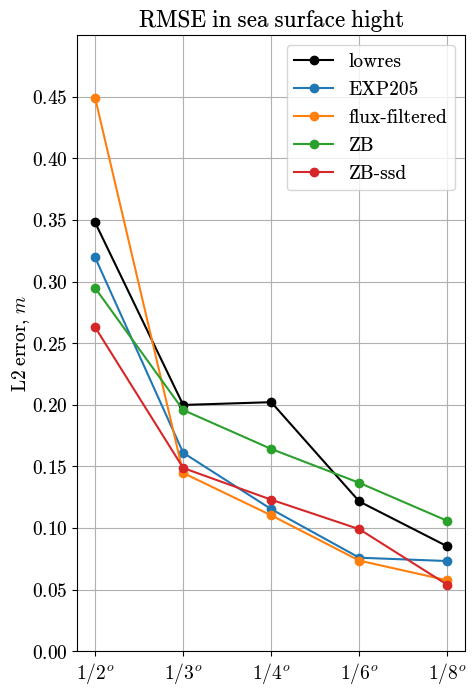

In [14]:
default_rcParams()
plt.figure(figsize=(5,8))
bare, ZB, ZB_ssd, exp205, mom = error_ssh(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.plot(x,ZB,label='ZB',marker='o')
plt.plot(x,ZB_ssd,label='ZB-ssd',marker='o')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(x,ticks)
plt.ylim([0,0.5])
plt.yticks(np.arange(0,0.50,0.05))
plt.grid()
plt.ylabel('L2 error, $m$')
plt.title('RMSE in sea surface hight')
#plt.savefig('generalization-ssh.pdf')

(0.0, 1.023058972703544)

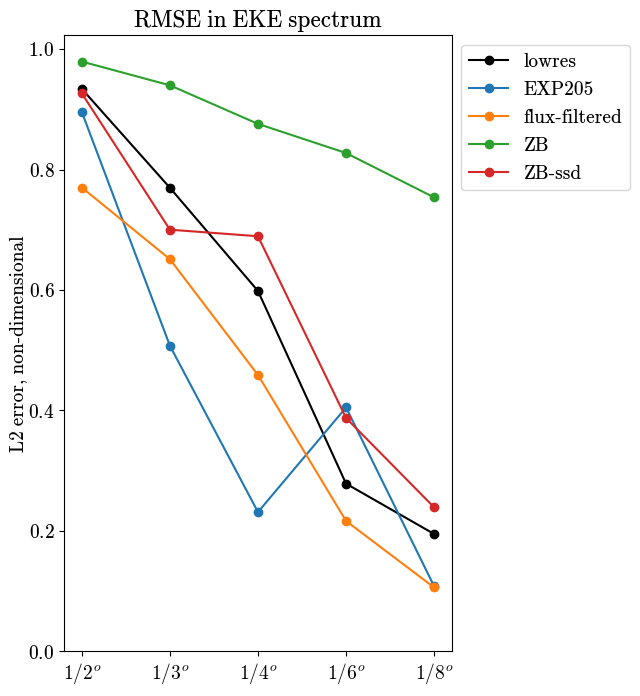

In [15]:
default_rcParams()
plt.figure(figsize=(5,8))
bare, ZB, ZB_ssd, exp205, mom = error_EKE_spectrum(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.plot(x,ZB,label='ZB',marker='o')
plt.plot(x,ZB_ssd,label='ZB-ssd',marker='o')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(x,ticks)
plt.ylabel('L2 error, non-dimensional')
plt.title('RMSE in EKE spectrum')
plt.ylim([0,None])
#plt.savefig('generalization-spectrum.pdf')

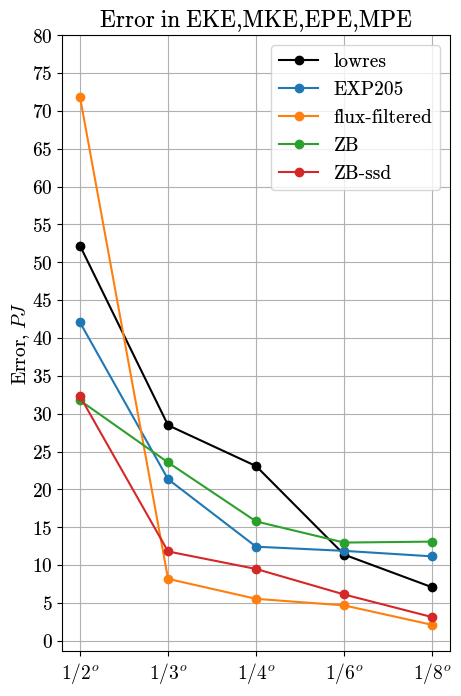

In [20]:
default_rcParams()
plt.figure(figsize=(5,8))
bare, ZB, ZB_ssd, exp205, mom = error_energetics(exps)
plt.plot(x,bare,label='lowres',color='k',marker='o')
plt.plot(x,exp205,label='EXP205',marker='o')
plt.plot(x,mom,label='flux-filtered',marker='o')
plt.plot(x,ZB,label='ZB',marker='o')
plt.plot(x,ZB_ssd,label='ZB-ssd',marker='o')
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(x,ticks)
plt.ylabel('Error, $PJ$')
plt.title('Error in EKE,MKE,EPE,MPE')
plt.yticks(np.arange(0,85,5));
plt.grid()
#plt.savefig('generalization-energetics.pdf')

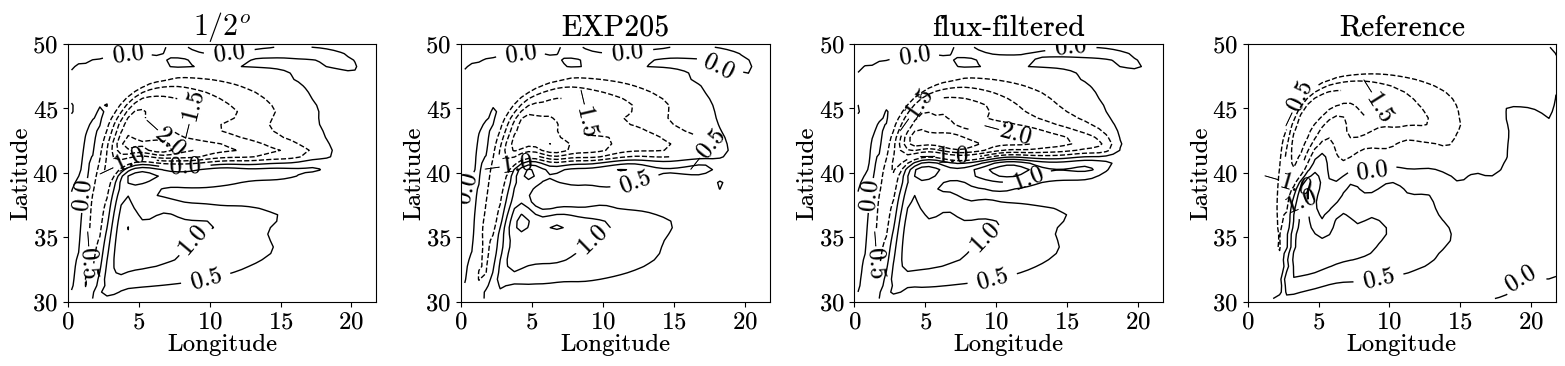

In [63]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R2_ref','R2_EXP205','R2_momf','R64_R2_ref'],labels=['$1/2^o$','EXP205','flux-filtered','Reference'])

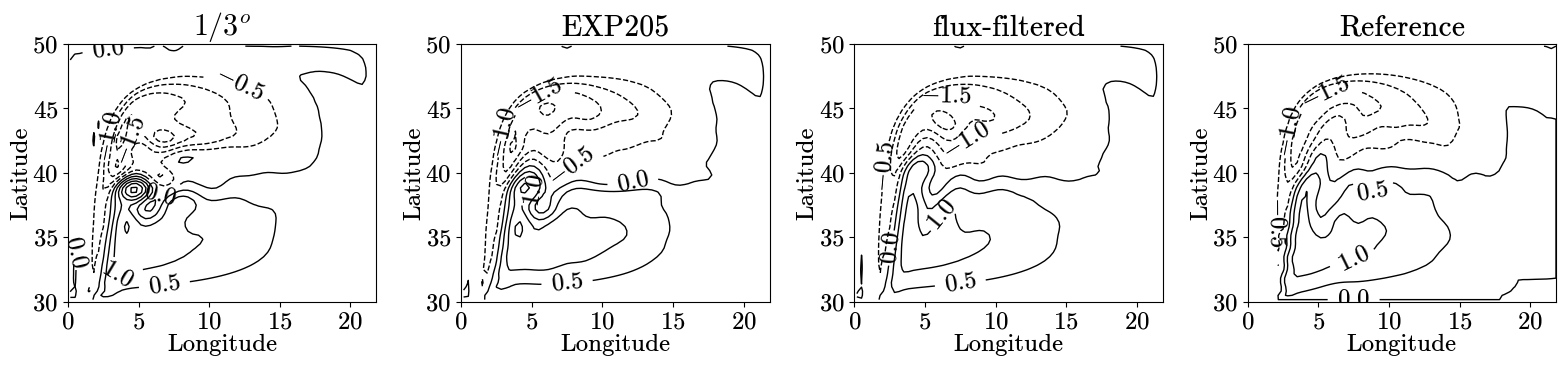

In [93]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R3_ref','R3_EXP205','R3_momf','R64_R3_ref'],labels=['$1/3^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-3.pdf')

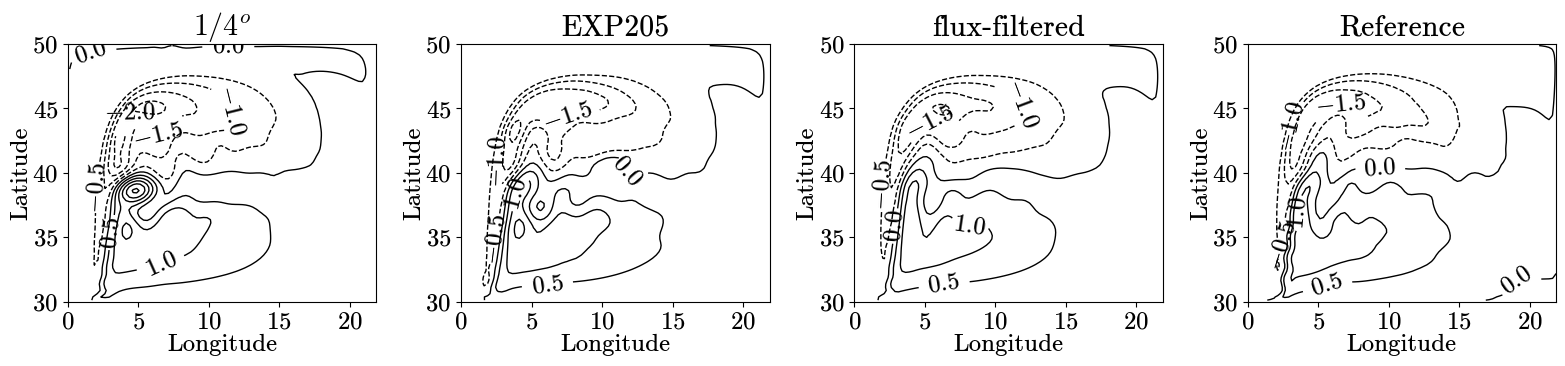

In [94]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-4.pdf')

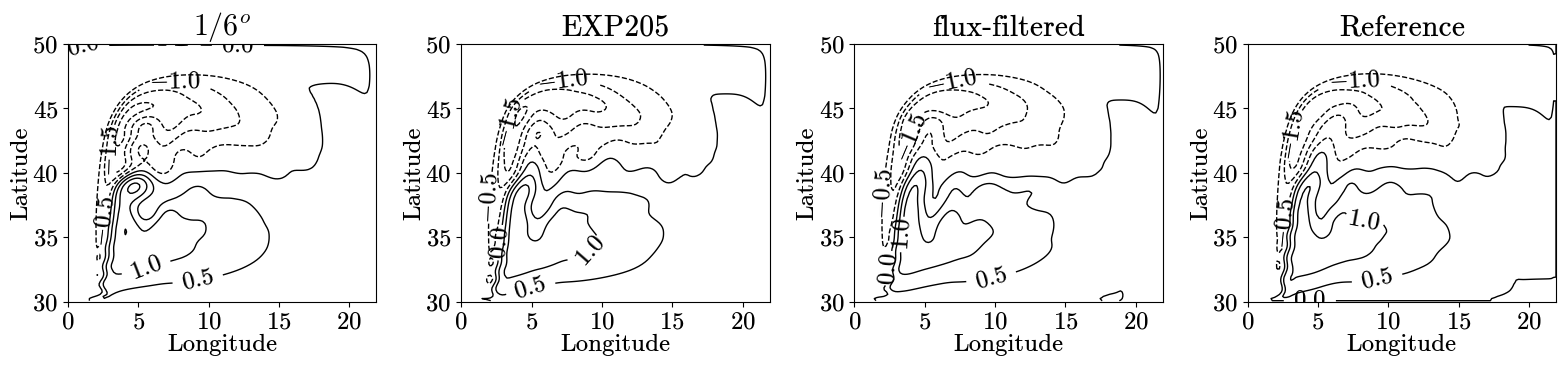

In [66]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R6_ref','R6_EXP205','R6_momf','R64_R6_ref'],labels=['$1/6^o$','EXP205','flux-filtered','Reference'])

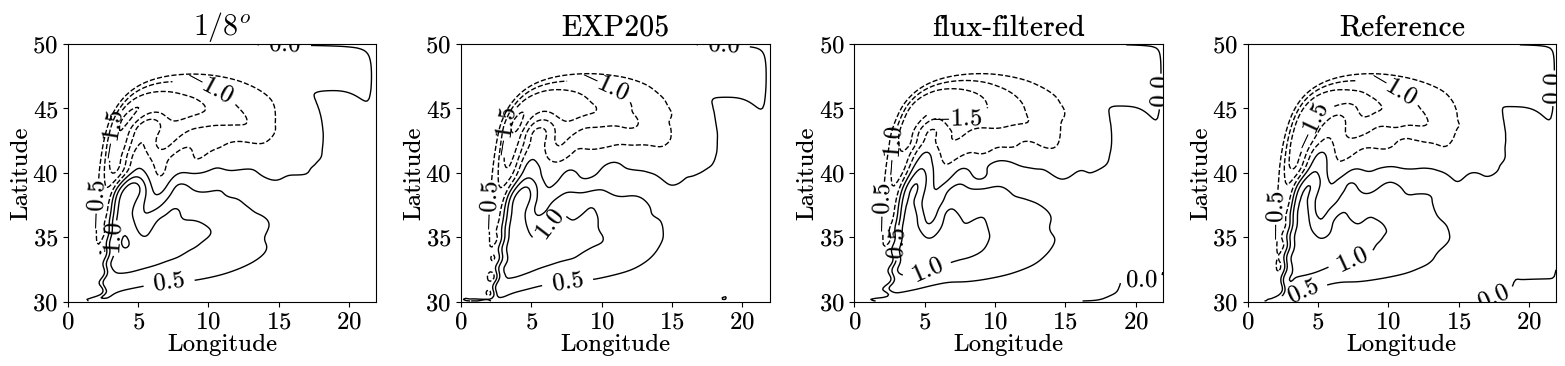

In [95]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R8_ref','R8_EXP205','R8_momf','R64_R8_ref'],labels=['$1/8^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-8.pdf')

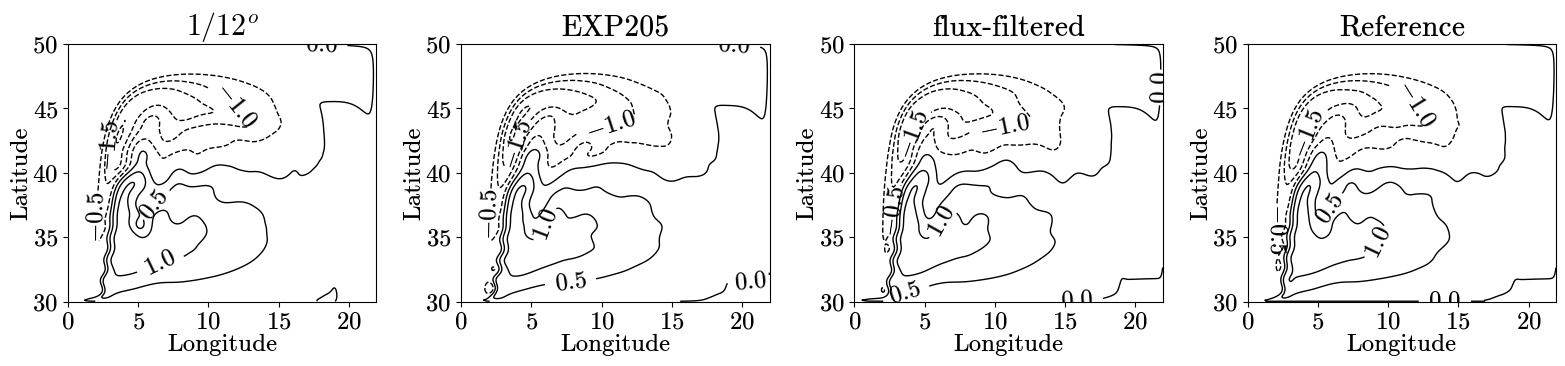

In [24]:
default_rcParams({'font.size':18})
ds.plot_ssh(['R12_ref','R12_EXP205','R12_momf','R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-filtered','Reference'])
plt.savefig('ssh-1-12.pdf')

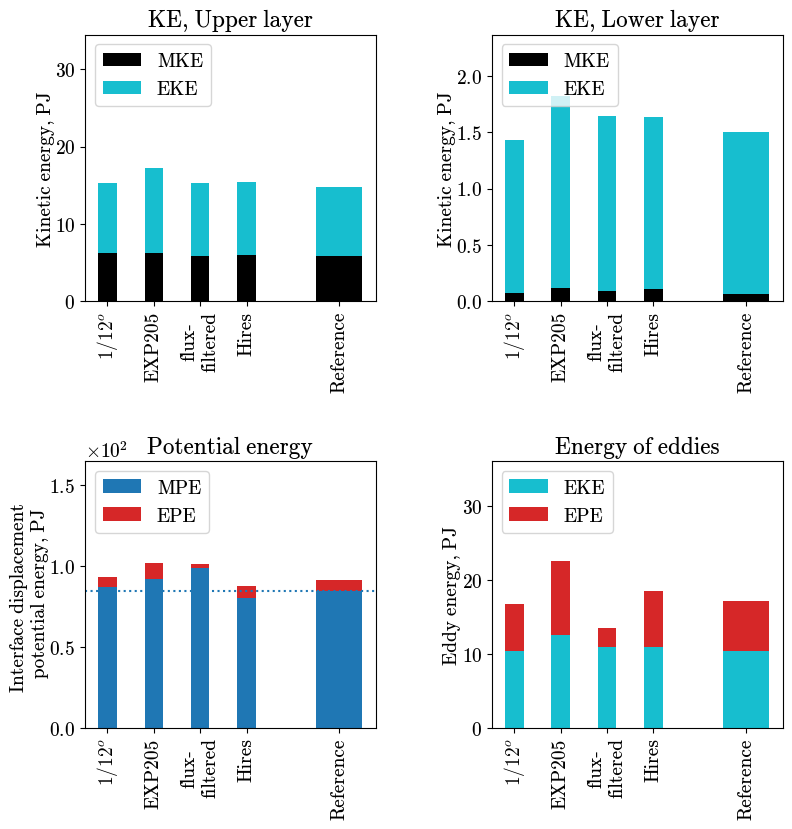

In [250]:
ds.plot_KE_PE(['R12_ref','R12_EXP205','R12_momf','R64', 'R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-\nfiltered','Hires', 'Reference'])

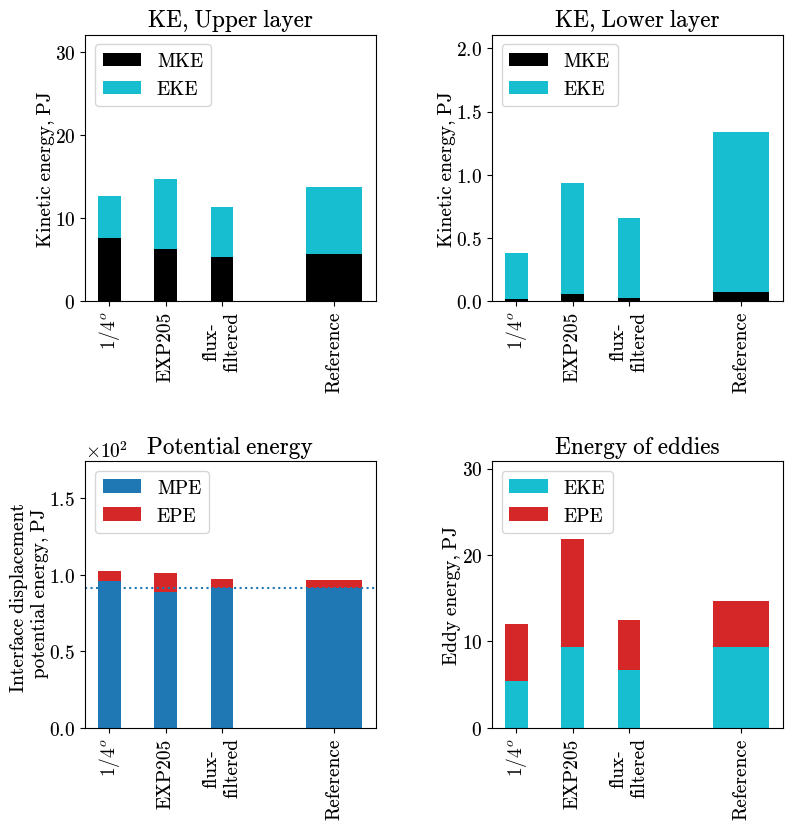

In [40]:
ds.plot_KE_PE(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-\nfiltered','Reference'])

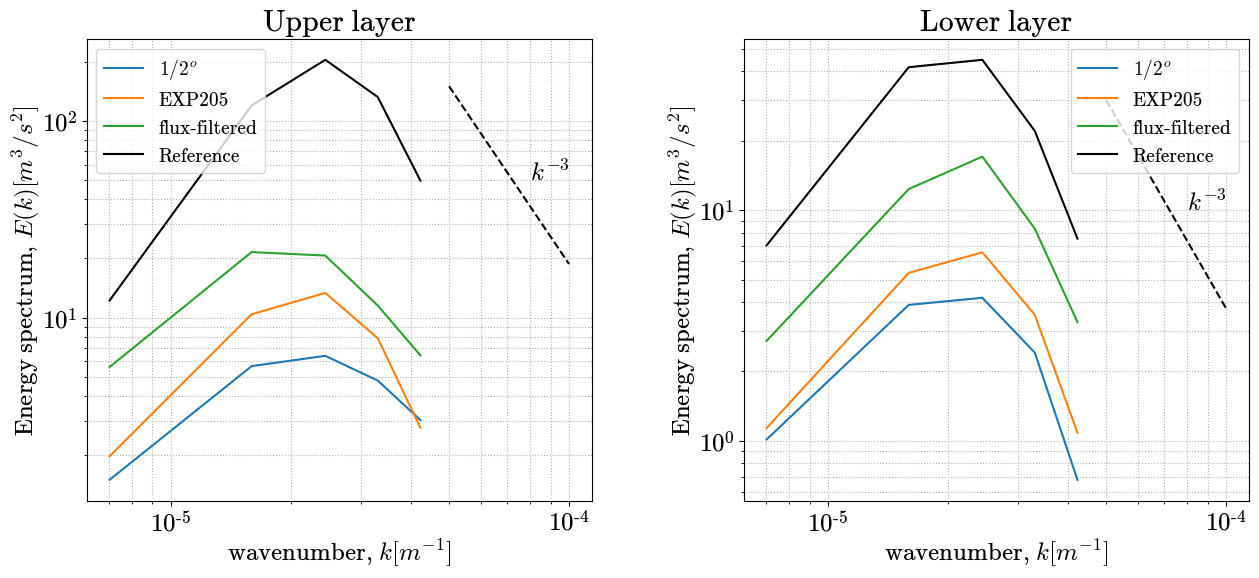

In [69]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R2_ref','R2_EXP205','R2_momf','R64_R2_ref'],labels=['$1/2^o$','EXP205','flux-filtered','Reference'])

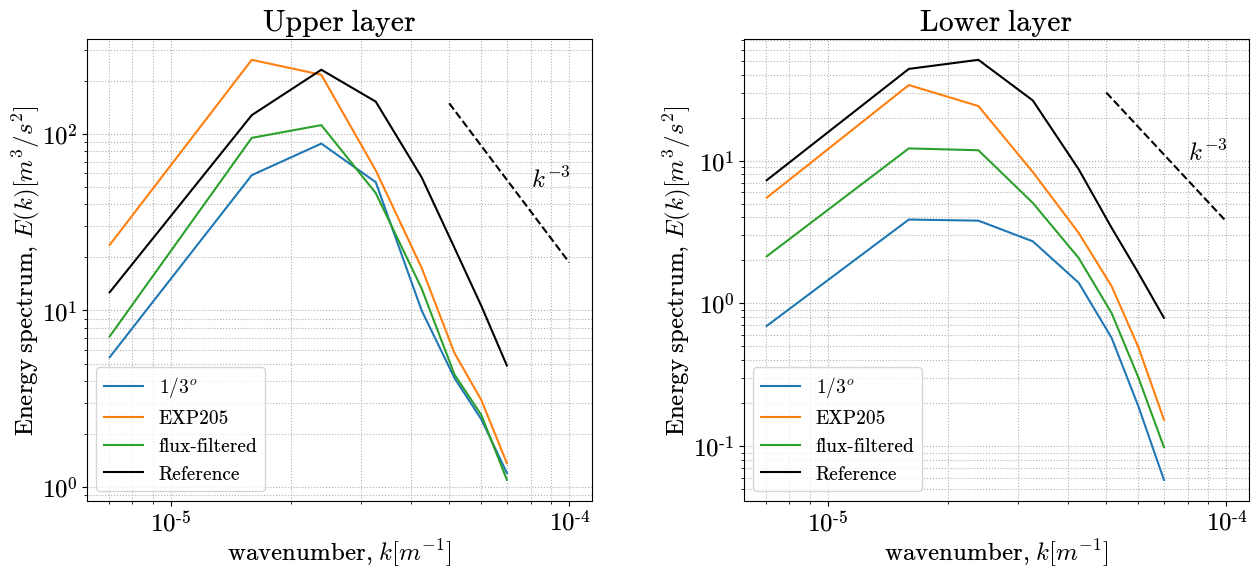

In [96]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R3_ref','R3_EXP205','R3_momf','R64_R3_ref'],labels=['$1/3^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-3.pdf')

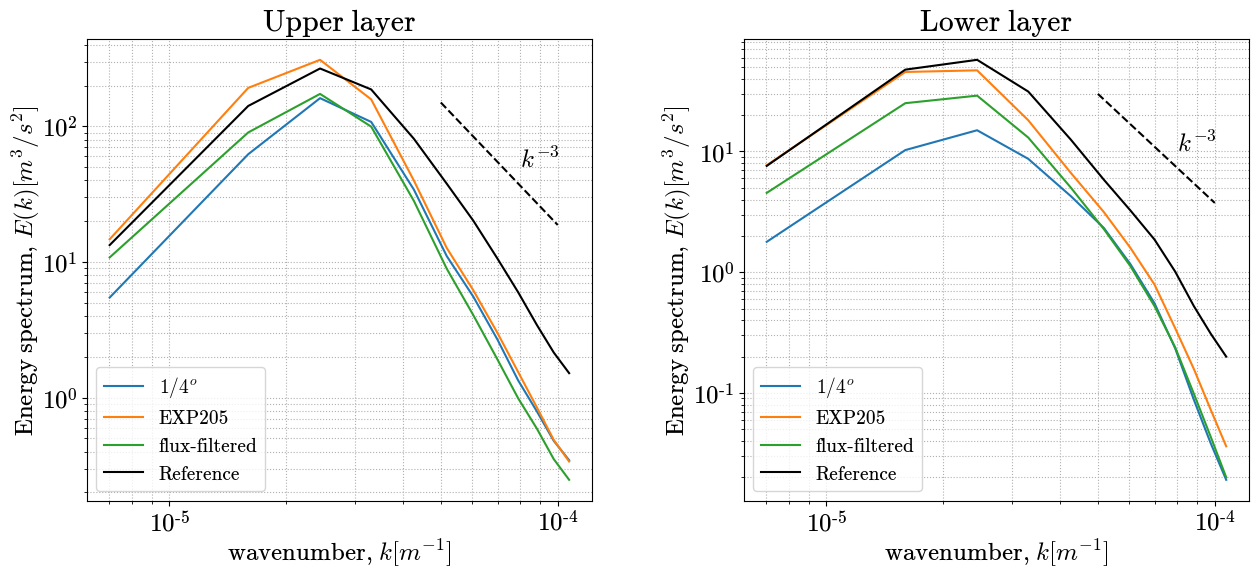

In [97]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R4_ref','R4_EXP205','R4_momf','R64_R4_ref'],labels=['$1/4^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-4.pdf')

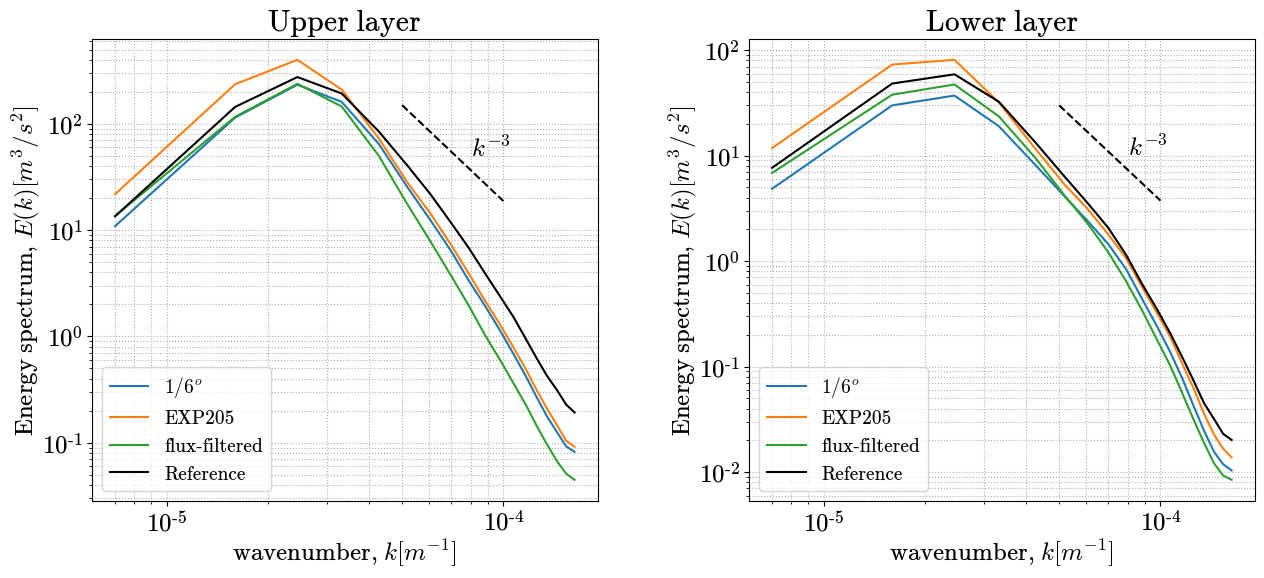

In [98]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R6_ref','R6_EXP205','R6_momf','R64_R6_ref'],labels=['$1/6^o$','EXP205','flux-filtered','Reference'])
plt.savefig('sp-1-6.pdf')

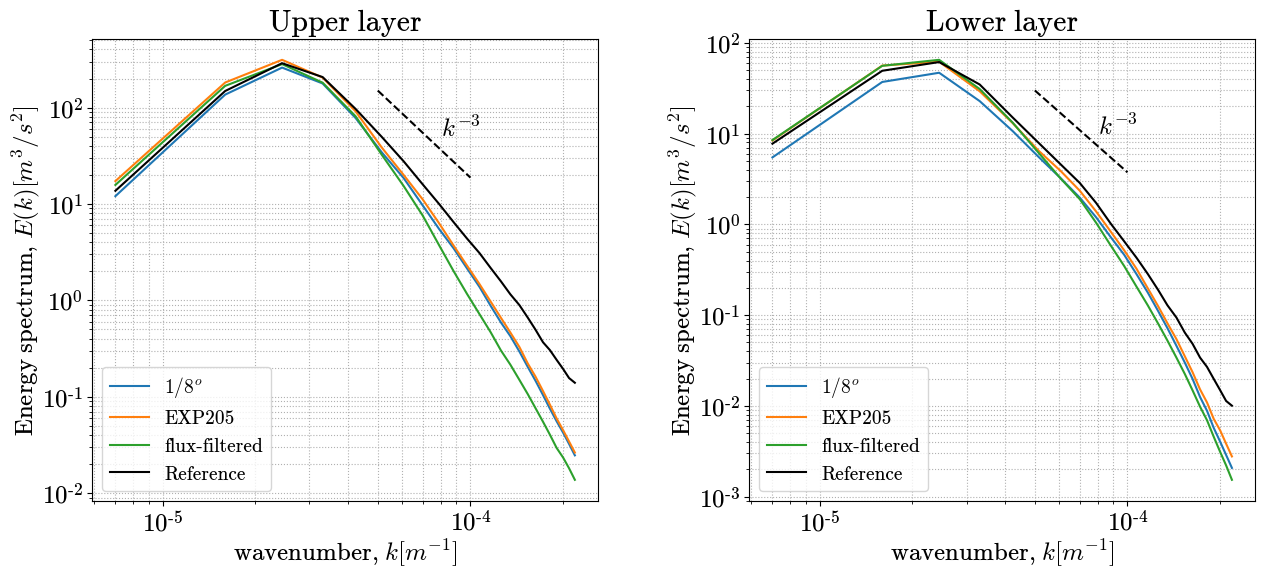

In [89]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R8_ref','R8_EXP205','R8_momf','R64_R8_ref'],labels=['$1/8^o$','EXP205','flux-filtered','Reference'])

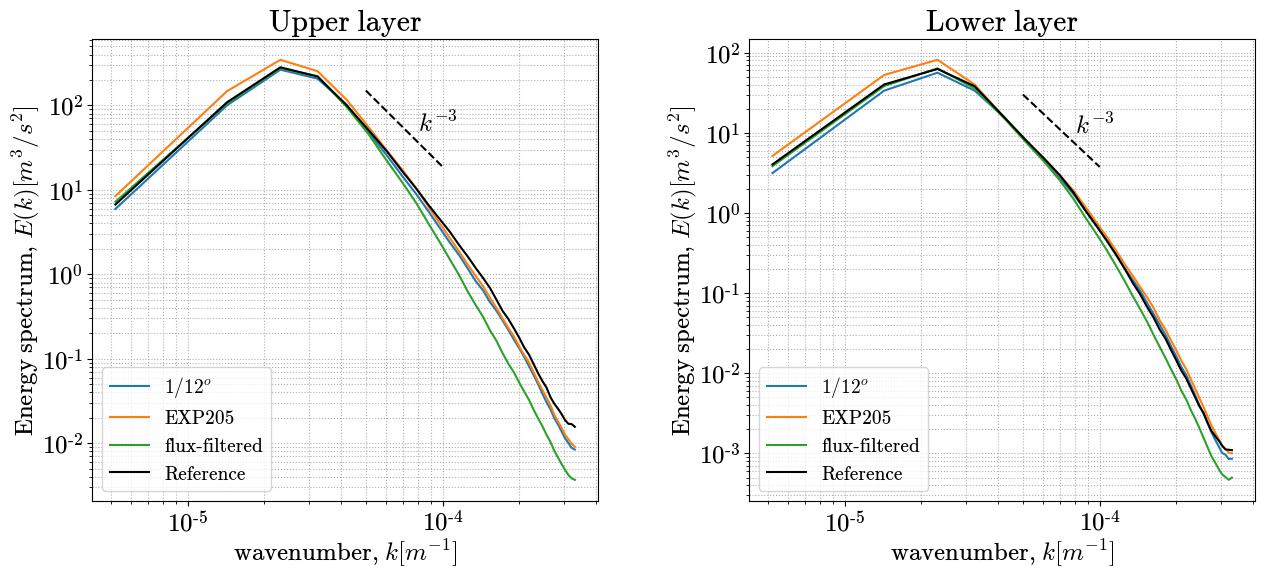

In [22]:
default_rcParams({'font.size':18})
ds.plot_KE_spectrum(['R12_ref','R12_EXP205','R12_momf','R64_R12_ref'],labels=['$1/12^o$','EXP205','flux-filtered','Reference'])

# Driving small scales

In [15]:
def KEspectrum(key):
    exp = ds[key]
    return compute_isotropic_KE(exp.u, exp.v, exp.param.dxT, exp.param.dyT, Lat=(30,50), Lon=(0,22), window=None, detrend=None, window_correction=False).sel(Time=slice(3650,7300)).mean(dim='Time')

In [16]:
ref = KEspectrum('R64_R4_ref').compute()

In [28]:
hires = KEspectrum('R32').compute()

In [17]:
coarse = KEspectrum('R4_ref').compute()

In [18]:
exp205 = KEspectrum('R4_EXP205').compute()

In [19]:
mom = KEspectrum('R4_momf').compute()

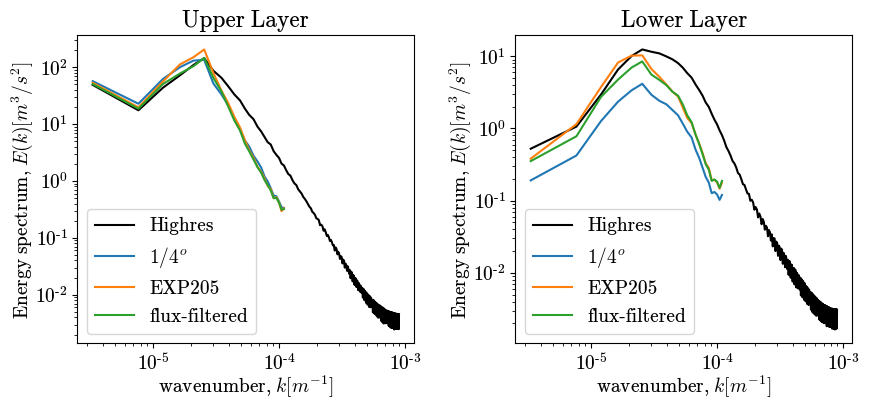

In [35]:
default_rcParams()
plt.figure(figsize=(10,4))
for zl in range(2):
    plt.subplot(1,2,zl+1)
    hires.isel(zl=zl).plot(label='Highres', color='k',xscale='log',yscale='log')
    coarse.isel(zl=zl).plot(label='$1/4^o$')
    exp205.isel(zl=zl).plot(label='EXP205')
    mom.isel(zl=zl).plot(label='flux-filtered')
    plt.legend()
    if zl==0:
        plt.title('Upper Layer')
    else:
        plt.title('Lower Layer')
    plt.xlabel(r'wavenumber, $k [m^{-1}]$')
    plt.ylabel(r'Energy spectrum, $E(k) [m^3/s^2]$')
plt.savefig('global_spectrum.pdf')

# Optimization of the filter
* Let typical resolution be 100x100 points
* Target filter:
\begin{equation}
    \mathrm{filter}(\phi_x,\phi_y) = \begin{cases}
                1, &\phi < 0.65 \pi \\
                \exp (-23.6 (\phi - 0.65 \pi)^4), & \text{otherwise}
            \end{cases}
\end{equation}
* Filter to be optimized:
\begin{equation}
    u_{\mathbf{k}}^{t+1} = u_{\mathbf{k}}^{t} \left( 1 - 4 \alpha \left( \sin^2(\frac{\phi_x}{2}) + \sin^2(\frac{\phi_y}{2}) \right) \cdot
    HPF(\phi_x,\phi_y)\right)
\end{equation}
* Where
\begin{equation}
    HPF(\phi_x,\phi_y) = \left(1-\left(\frac{1}{4} \left(1+\cos(\phi_x)\right) \left(1+\cos(\phi_y)\right)\right)\right)^n.
\end{equation}
* Setting chess harmonic to zero, we get $\alpha=1/8$; But we let it be a free parameter

In [45]:
px, py = np.meshgrid(np.linspace(0,np.pi,50),np.linspace(0,np.pi,50))

In [225]:
def contour(x,y,z):
    plt.contourf(x,y,z,levels=[0,0.25,0.5,0.75,0.9,0.95,0.99,1])
    Cplot = plt.contour(x,y,z,levels=[0,0.25,0.5,0.75,0.9,0.95,0.99],colors='k')
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks([0,np.pi/3,2*np.pi/3,np.pi],['$0$','$\pi/3$','$2\pi/3$','$\pi$'])
    plt.yticks([0,np.pi/3,2*np.pi/3,np.pi],['$0$','$\pi/3$','$2\pi/3$','$\pi$'])

In [248]:
def half_life(x,y,z):
    z = np.log(1/2)/np.log(z)
    levels = [1, 2, 5, 10, 50, 100,1000]
    #plt.contourf(x,y,z,levels=levels)
    Cplot = plt.contour(x,y,z,levels=levels,colors='k')
    plt.gca().clabel(Cplot, Cplot.levels)
    plt.xticks([0,np.pi/4, np.pi/2,2*np.pi/3,np.pi],['$0$','$\pi/4$', '$\pi/2$','$2\pi/3$','$\pi$'])
    plt.yticks([0,np.pi/4, np.pi/2,2*np.pi/3,np.pi],['$0$','$\pi/4$', '$\pi/2$','$2\pi/3$','$\pi$'])

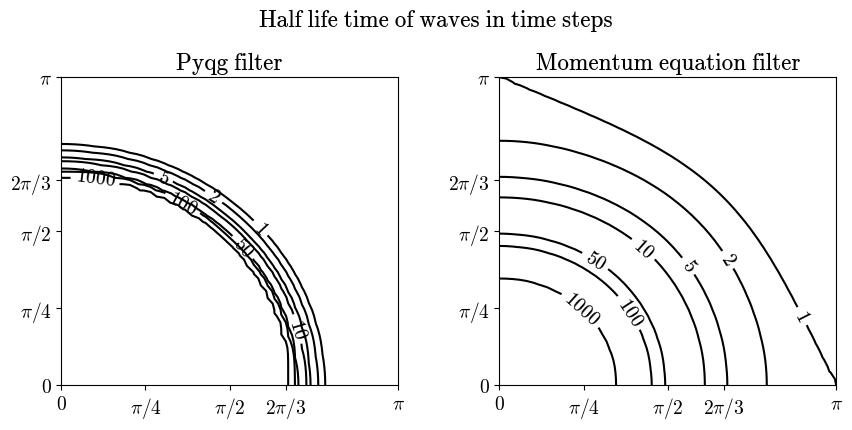

In [370]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
half_life(px,py,target(px,py))
plt.title('Pyqg filter')
plt.subplot(1,2,2)
half_life(px,py,lapfilter(px,py,n=4,alpha=1/8));
plt.title('Momentum equation filter')
plt.suptitle('Half life time of waves in time steps', y=1.05)
plt.savefig('half-time.pdf')

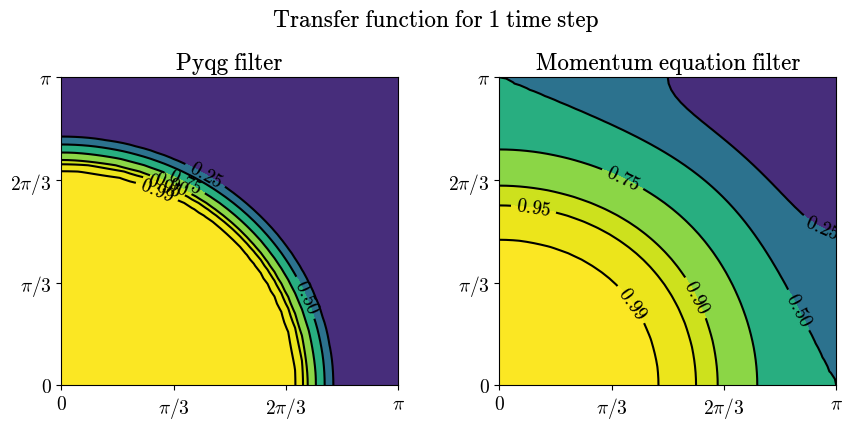

In [372]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
contour(px,py,target(px,py))
plt.title('Pyqg filter')
plt.subplot(1,2,2)
contour(px,py,lapfilter(px,py,n=4,alpha=1/8));
plt.title('Momentum equation filter')
plt.suptitle('Transfer function for 1 time step', y=1.05)
plt.savefig('transfer-function.pdf')

In [140]:
def target(px,py):
    cphi=0.65*np.pi
    phi = np.sqrt(px**2+py**2)
    filtr = np.exp(-23.6*(phi-cphi)**4.)
    filtr[phi<=cphi] = 1.
    return filtr

In [141]:
def HPF(px,py,n=1):
    return (1 - 1/4*(1+np.cos(px))*(1+np.cos(py)))**float(n)

In [142]:
def lapfilter(px,py,n=1,alpha=1/8):
    return 1-4*alpha*((np.sin(px/2))**2.+(np.sin(py/2))**2.)*HPF(px,py,n)

In [338]:
def bilapsmag(px,py,nu=6543189740.382907):
    '''
    viscosity nu is suitable for R4 resolution
    '''
    dx = 27000
    dt = 1080
    return 1 - nu * ((px/dx)**2+(py/dx)**2)**2 * dt

In [143]:
def L2_metric(n=1,alpha=1/8,nsteps=1):
    error = (target(px,py))**float(nsteps) - (lapfilter(px,py,n,alpha))**float(nsteps)
    return np.sqrt((error**2).mean())

In [159]:
for n in range(11):
    print(n, L2_metric(n,nsteps=1))

0 0.29966245635009686
1 0.2741038993931576
2 0.2724053766102314
3 0.2799538504439871
4 0.29113744402796526
5 0.30351310506440904
6 0.31597301630587493
7 0.32801530251573047
8 0.33942558625922004
9 0.3501296404463875
10 0.3601221109885186


In [151]:
L2_metric(n=8,nsteps=10)

0.10465721462030667

In [202]:
0.99**68

0.5048858887870696

In [201]:
np.log(1/2)/np.log(0.99)

68.96756393652842

# Governing equation filter

In [5]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/gov-eq-filter/bare', additional_subfolder='output')

In [6]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/gov-eq-filter/ZB-ssd-4-iter', additional_subfolder='output',prefix='ZB-4-iter')

In [7]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/gov-eq-filter/ZB-ssd-10-iter', additional_subfolder='output',prefix='ZB-10-iter')


In [8]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/gov-eq-filter/ZB-ssd-10-iter-0.2', additional_subfolder='output',prefix='ZB-10-iter-0.2')


In [9]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/gov-eq-filter/ZB-ssd-10-iter-0.8', additional_subfolder='output',prefix='ZB-10-iter-0.8')


In [9]:
ds.exps

['R16',
 'R2',
 'R3',
 'R32',
 'R4',
 'R5',
 'R6',
 'R64',
 'R7',
 'R8',
 'R10_EXP205',
 'R10_momf',
 'R10_ref',
 'R12_EXP205',
 'R12_momf',
 'R12_ref',
 'R2_EXP205',
 'R2_EXP205-repeat',
 'R2_ZB',
 'R2_ZB-ssd',
 'R2_momf',
 'R2_ref',
 'R3_EXP205',
 'R3_ZB',
 'R3_ZB-ssd',
 'R3_momf',
 'R3_ref',
 'R4_EXP205',
 'R4_EXP205-repeat',
 'R4_ZB',
 'R4_ZB-repeat',
 'R4_ZB-ssd',
 'R4_momf',
 'R4_ref',
 'R6_EXP205',
 'R6_ZB',
 'R6_ZB-ssd',
 'R6_momf',
 'R6_ref',
 'R8_EXP205',
 'R8_ZB',
 'R8_ZB-ssd',
 'R8_momf',
 'R8_ref',
 'EXP111',
 'EXP112',
 'EXP113',
 'EXP114',
 'EXP115',
 'EXP116',
 'EXP117',
 'EXP118',
 'EXP119',
 'EXP120',
 'EXP121',
 'EXP122',
 'EXP123',
 'EXP124',
 'EXP125',
 'EXP126',
 'EXP127',
 'EXP128',
 'EXP129',
 'EXP130',
 'EXP131',
 'EXP132',
 'EXP133',
 'EXP134',
 'EXP135',
 'EXP136',
 'EXP137',
 'EXP138',
 'EXP139',
 'EXP140',
 'EXP141',
 'EXP142',
 'EXP143',
 'EXP144',
 'EXP145',
 'EXP146',
 'EXP147',
 'EXP148',
 'EXP149',
 'EXP150',
 'EXP151',
 'EXP152',
 'EXP153',
 'EXP154',

In [13]:
ds['R64_R4']

item not found


Text(0.0001, 0.01, '$\\frac{\\pi}{\\Delta x}$')

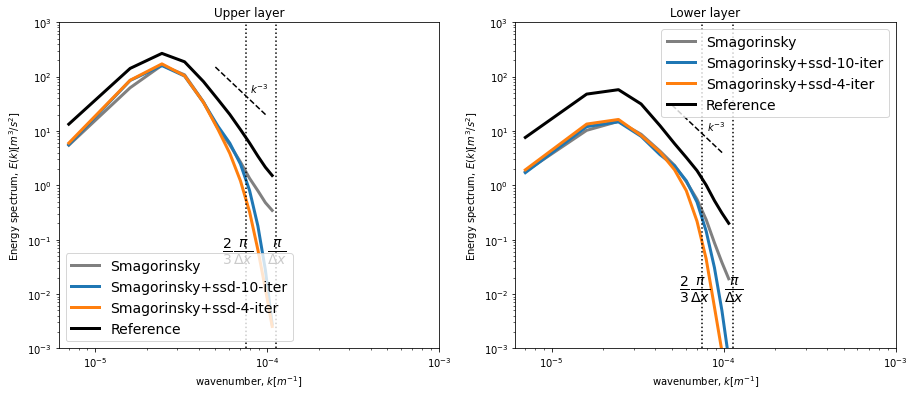

In [39]:
ds.plot_KE_spectrum(['R4_ref', 'ZB-10-iter-0.2-amplitude-0.0', 'ZB-4-iter-amplitude-0.0', 'R64_R4'], labels=['Smagorinsky', 'Smagorinsky+ssd-10-iter', 'Smagorinsky+ssd-4-iter','Reference'])
kmax = ds['R4_ref'].kmax
plt.subplot(1,2,1)
plt.axvline(x=kmax, ls=':', color='k')
plt.axvline(x=2/3*kmax, ls=':', color='k')
plt.text(5.5e-5,5e-2,r'$\frac{2}{3} \frac{\pi}{\Delta x}$', fontsize=20)
plt.text(1e-4,5e-2,r'$\frac{\pi}{\Delta x}$', fontsize=20)
plt.subplot(1,2,2)
plt.axvline(x=kmax, ls=':', color='k')
plt.axvline(x=2/3*kmax, ls=':', color='k')
plt.text(5.5e-5,1e-2,r'$\frac{2}{3} \frac{\pi}{\Delta x}$', fontsize=20)
plt.text(1e-4,1e-2,r'$\frac{\pi}{\Delta x}$', fontsize=20)
#plt.savefig('small-scale-dissipation.pdf')

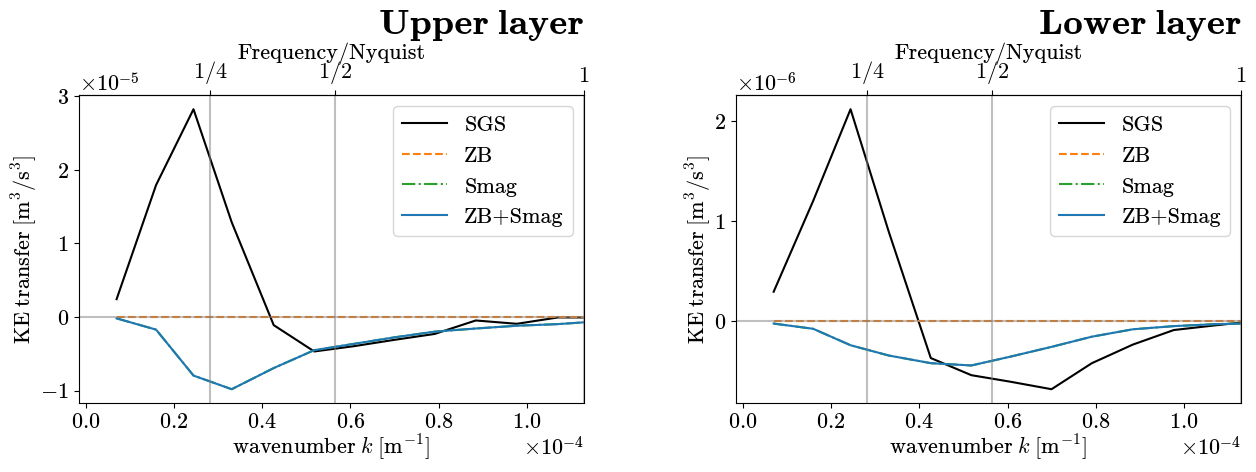

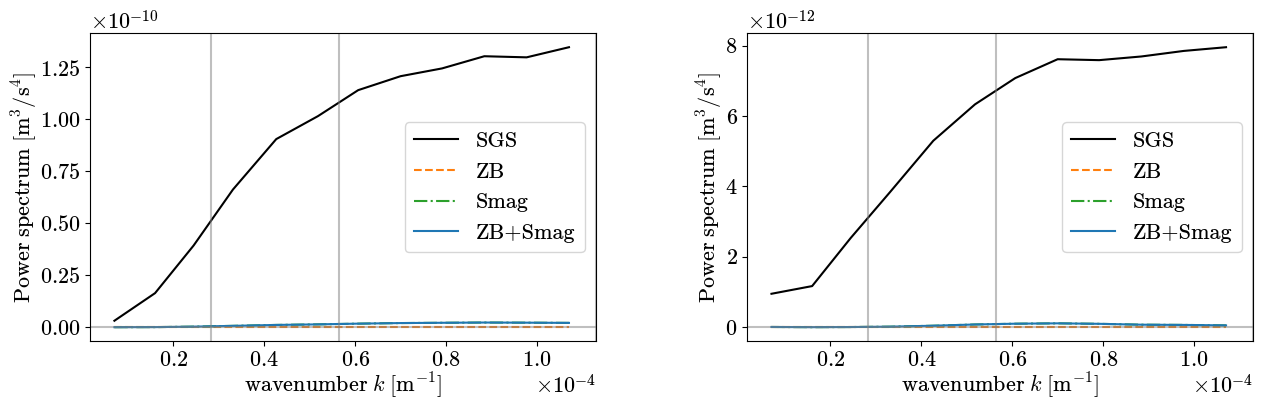

In [486]:
ds.plot_transfer('R4_ref')

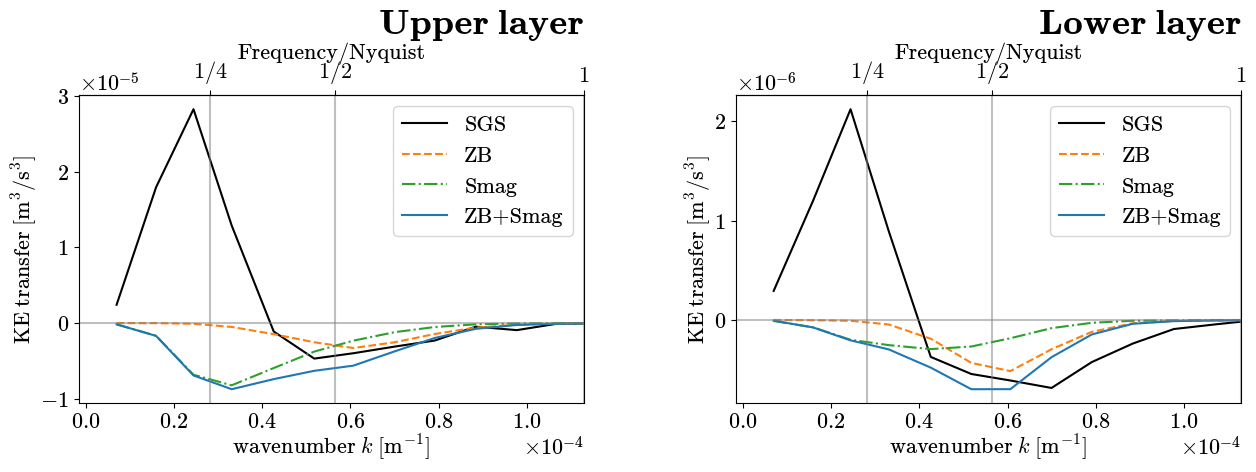

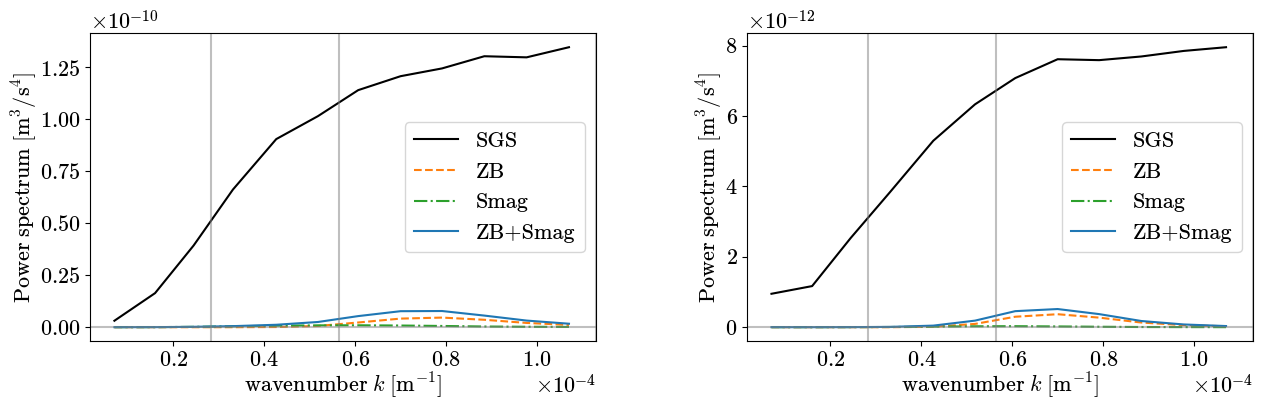

In [487]:
ds.plot_transfer('R4-filter-4-0.05')

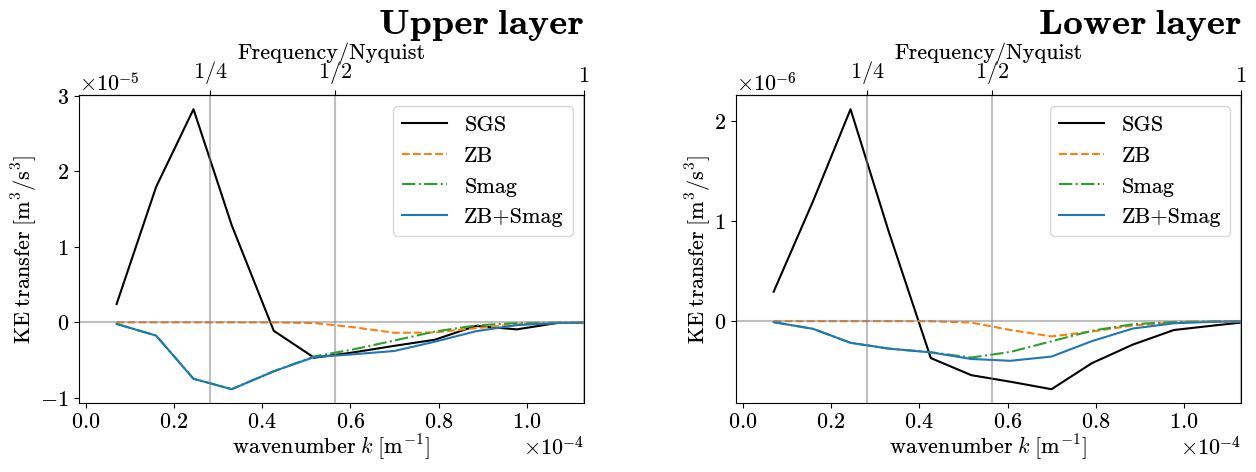

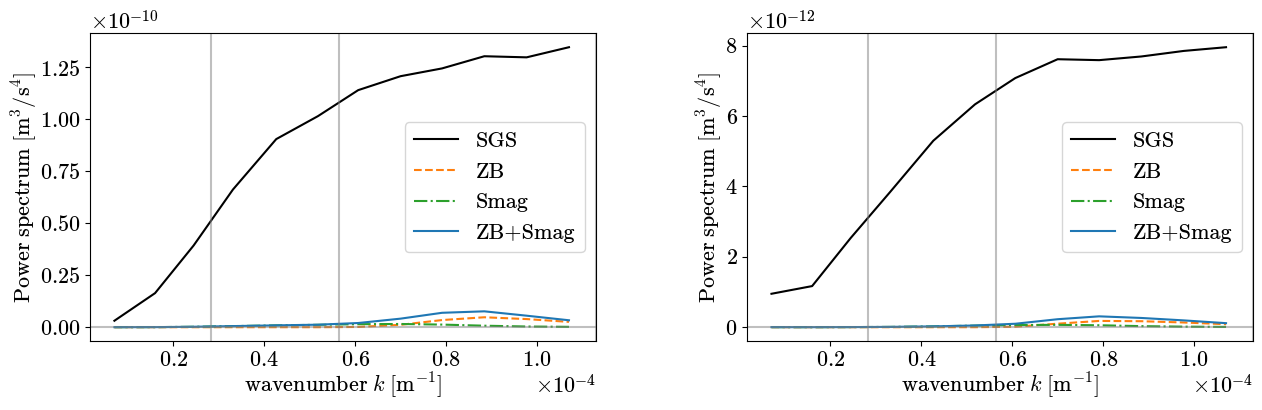

In [496]:
ds.plot_transfer('ZB-10-iter-0.2-amplitude-0.0')

Text(0.5, 1.0, '')

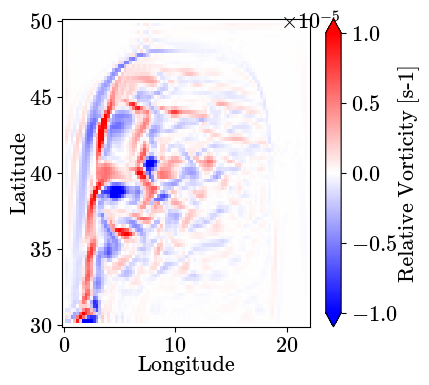

In [504]:
ds['R4_ref'].RV.isel(zl=0,Time=-1).plot(vmin=-1e-5,vmax=1e-5,cmap='bwr')
plt.title('')

Text(0.5, 1.0, '')

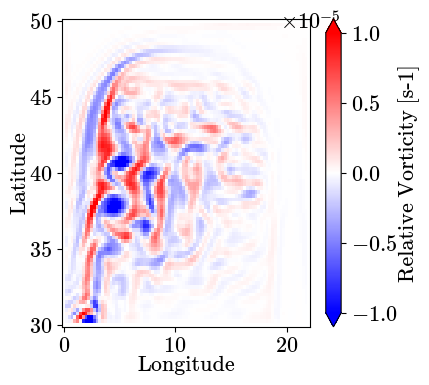

In [512]:
ds['R4-filter-10-0.2'].RV.isel(zl=0,Time=-1).plot(vmin=-1e-5,vmax=1e-5,cmap='bwr')
plt.title('')

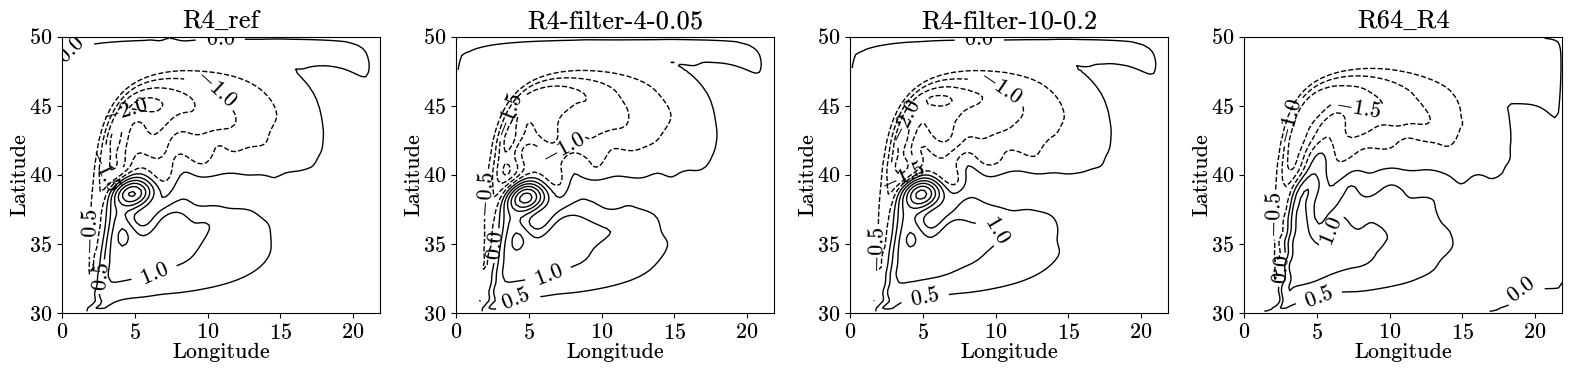

In [517]:
ds.plot_ssh(['R4_ref', 'R4-filter-4-0.05', 'R4-filter-10-0.2','R64_R4'])

In [518]:
Lk_error(ds['R4_ref'].ssh_mean, ds['R64_R4'].ssh_mean)

[0.34968376]

In [521]:
Lk_error(ds['R4-filter-10-0.2'].ssh_mean, ds['R64_R4'].ssh_mean)

[0.38023064]

# Ranking of online simulations

In [16]:
def energy_metric(exp, target='R64_R4'):
    return sum(ds[exp].Lk_error(ds[target], features=['EKE_joul','MKE_joul','EPE_joul','MPE_joul'])[0])/6

In [17]:
def plot_min(x,y,**kw):
    j = np.nanargmin(y)
    line = plt.plot(x,y,**kw)
    plt.plot(x[j],y[j],marker='o',color=line[0].get_color())
    plt.axhline(y=y[j], ls='--',color=line[0].get_color())

In [18]:
def plot_amp_error(amp=np.linspace(0,10,41),exps=[f'best-EXP{j}' for j in range(41)]):
    plt.figure(figsize=(7,4))
    error = np.zeros((len(amp),4))*np.nan
    for j,exp in enumerate(exps):
        try:
            error[j,:2] = Lk_error(ds[exp].EKE_spectrum,ds['R64_R4'].EKE_spectrum)
            error[j,2:3] = Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)
            error[j,3] = energy_metric(exp)
        except:
            pass
    plot_min(amp,error[:,0], label='upper EKE spectrum')
    plot_min(amp,error[:,1], label='lower EKE spectrum')
    plot_min(amp,error[:,2], label='ssh')
    plot_min(amp,error[:,3], label='Energy metric')
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel('Ampllitude')
    plt.ylabel('Non-dimensional online metric')
    plt.ylim([0,1])

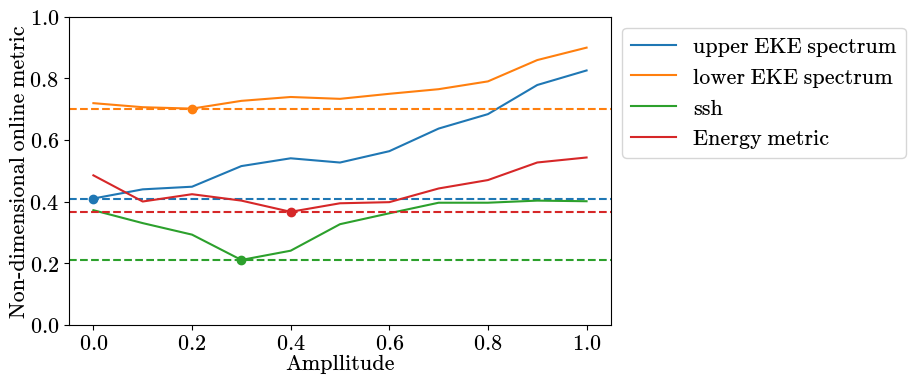

In [530]:
plot_amp_error(amp=[i/10. for i in range(11)], exps=[f'ZB-4-iter-amplitude-{str(i/10.)}' for i in range(11)])

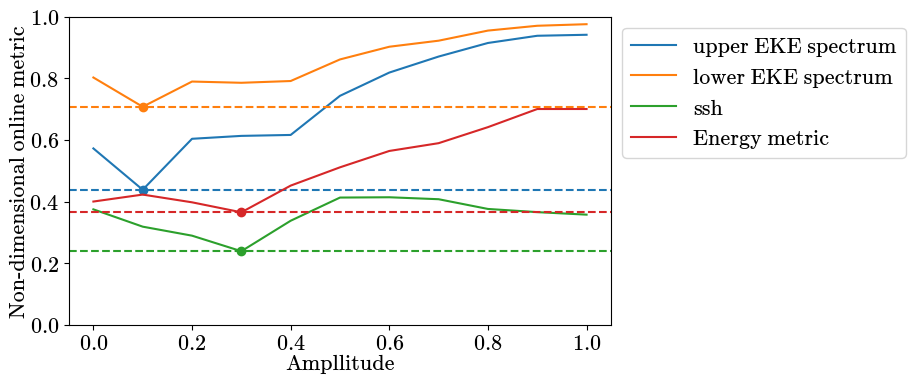

In [531]:
plot_amp_error(amp=[i/10. for i in range(11)], exps=[f'ZB-10-iter-amplitude-{str(i/10.)}' for i in range(11)])

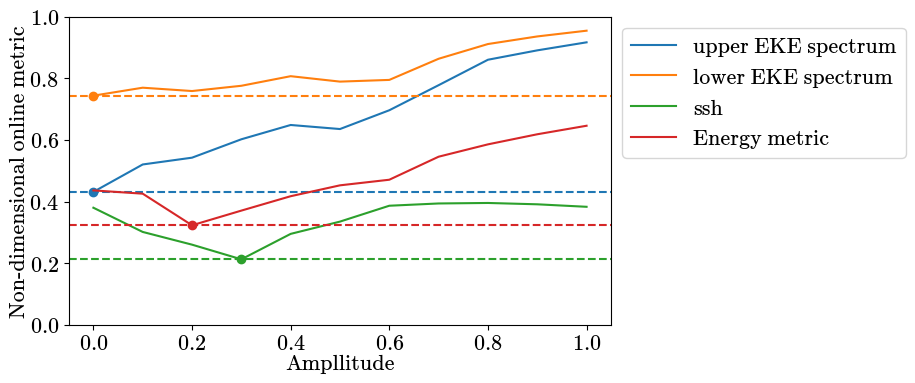

In [532]:
plot_amp_error(amp=[i/10. for i in range(11)], exps=[f'ZB-10-iter-0.2-amplitude-{str(i/10.)}' for i in range(11)])

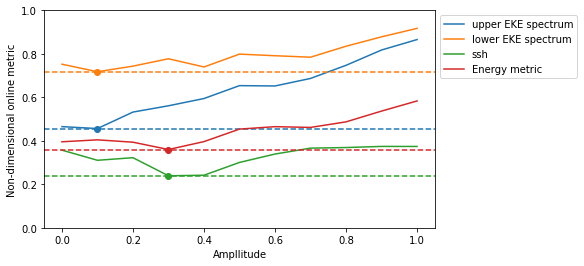

In [19]:
plot_amp_error(amp=[i/10. for i in range(11)], exps=[f'ZB-10-iter-0.8-amplitude-{str(i/10.)}' for i in range(11)])

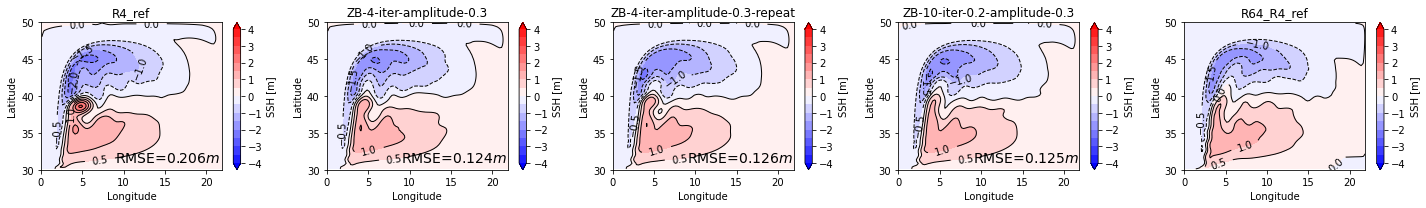

In [21]:
ds.plot_ssh(['R4_ref','ZB-4-iter-amplitude-0.3', 'ZB-4-iter-amplitude-0.3-repeat', 'ZB-10-iter-0.2-amplitude-0.3','R64_R4_ref'])

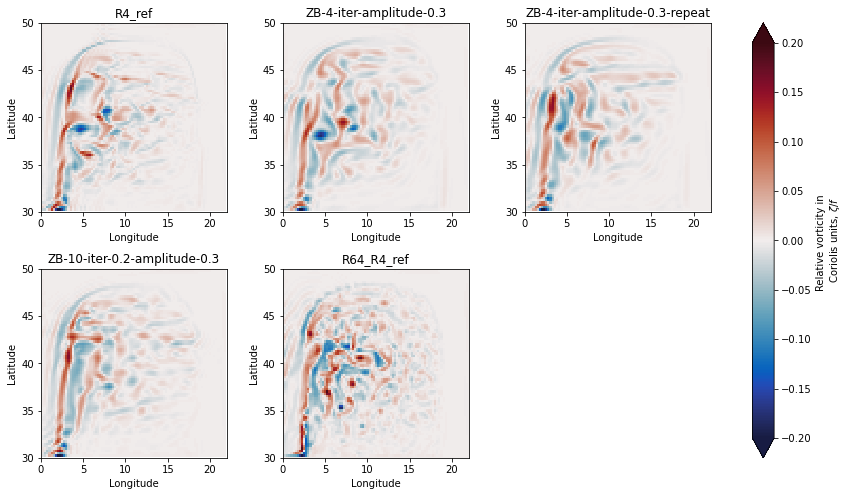

In [10]:
ds.plot_RV(['R4_ref','ZB-4-iter-amplitude-0.3', 'ZB-4-iter-amplitude-0.3-repeat', 'ZB-10-iter-0.2-amplitude-0.3','R64_R4_ref'])


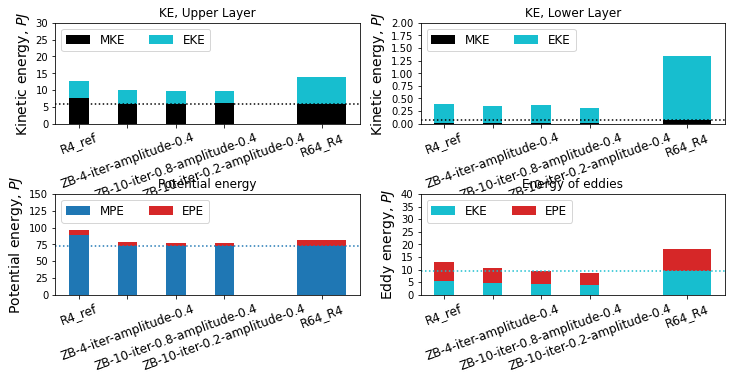

In [65]:
ds.plot_KE_PE(['R4_ref','ZB-4-iter-amplitude-0.4', 'ZB-10-iter-0.8-amplitude-0.4', 'ZB-10-iter-0.2-amplitude-0.4','R64_R4'])

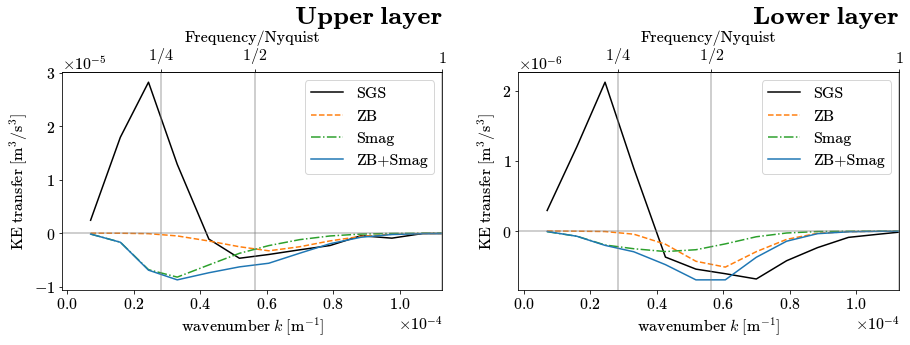

In [70]:
ds.plot_transfer('ZB-4-iter-amplitude-0.0', callback=False)



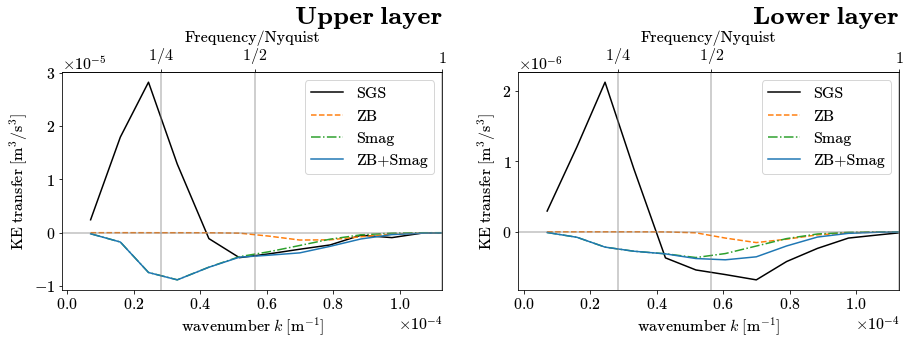

In [71]:
ds.plot_transfer('ZB-10-iter-0.2-amplitude-0.0', callback=False)



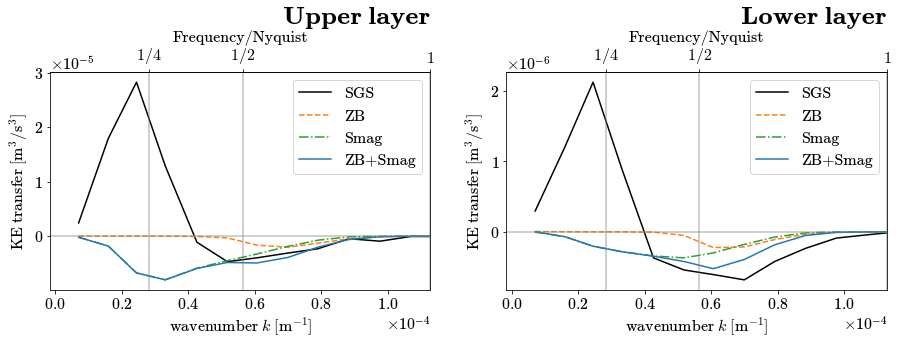

In [72]:
ds.plot_transfer('ZB-10-iter-0.8-amplitude-0.0', callback=False)



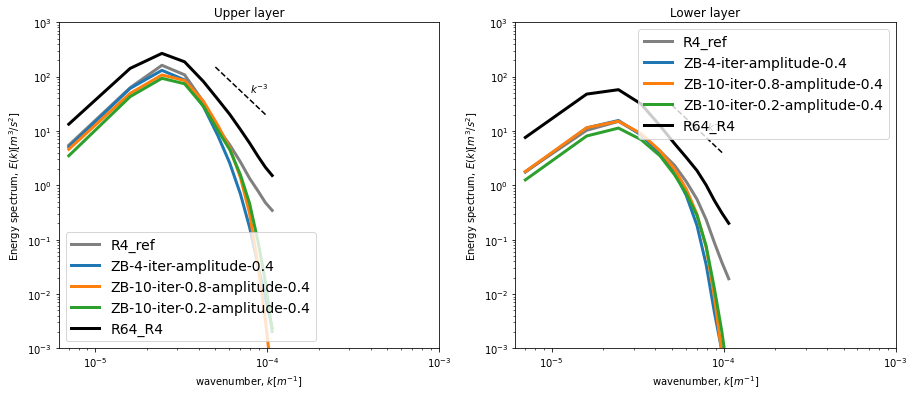

In [63]:
ds.plot_KE_spectrum(['R4_ref','ZB-4-iter-amplitude-0.4', 'ZB-10-iter-0.8-amplitude-0.4', 'ZB-10-iter-0.2-amplitude-0.4','R64_R4'])

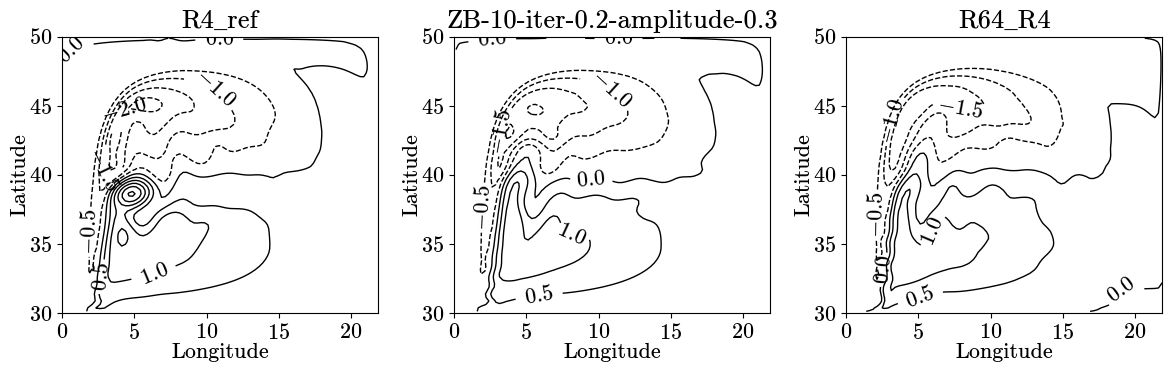

In [577]:
ds.plot_ssh(['R4_ref', 'ZB-10-iter-0.2-amplitude-0.3','R64_R4'])

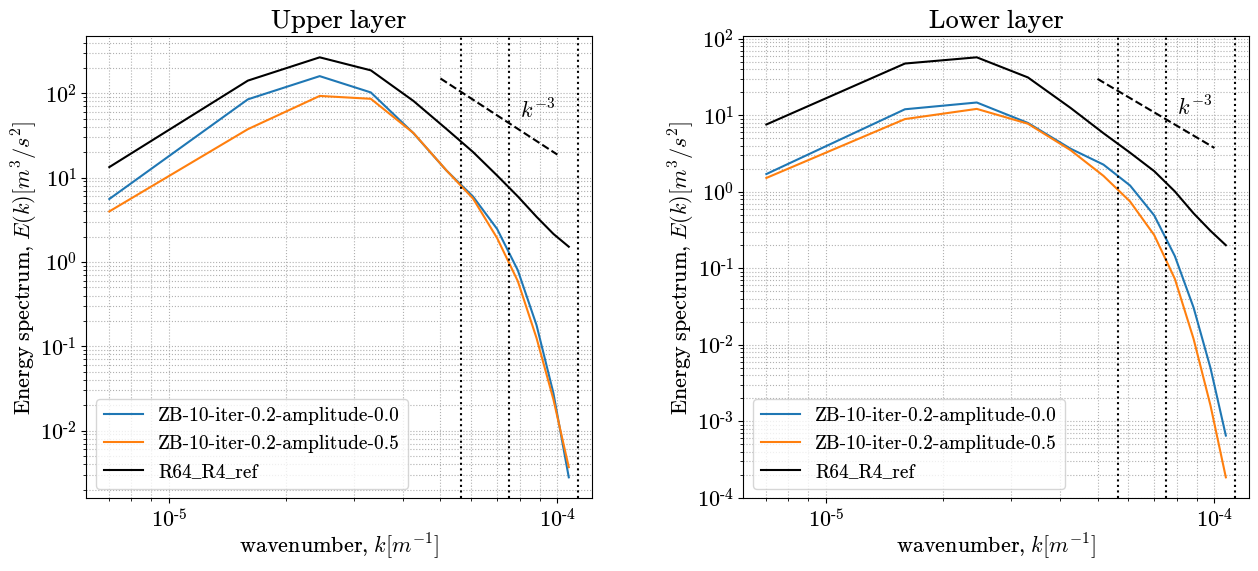

In [575]:
ds.plot_KE_spectrum(['ZB-10-iter-0.2-amplitude-0.0', 'ZB-10-iter-0.2-amplitude-0.5', 'R64_R4_ref'])
kmax = ds['R4_ref'].kmax
plt.subplot(1,2,1)
plt.axvline(x=kmax, ls=':', color='k')
plt.axvline(x=0.5*kmax, ls=':', color='k')
plt.axvline(x=2/3*kmax, ls=':', color='k')
plt.subplot(1,2,2)
plt.axvline(x=kmax, ls=':', color='k')
plt.axvline(x=0.5*kmax, ls=':', color='k')
plt.axvline(x=2/3*kmax, ls=':', color='k')

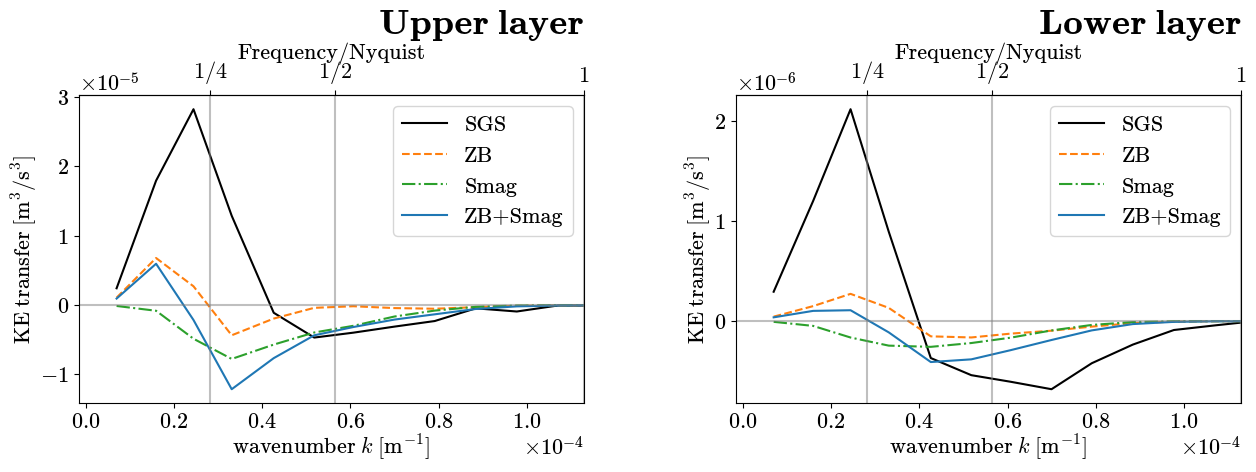

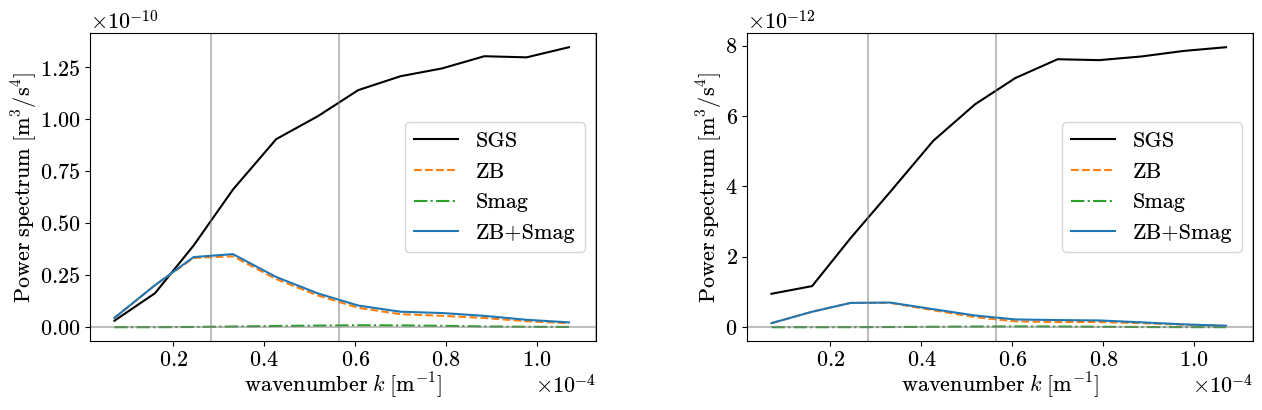

In [576]:
ds.plot_transfer('ZB-10-iter-0.2-amplitude-0.5')

In [571]:
Lk_error(ds['ZB-4-iter-amplitude-0.3'].ssh_mean, ds['R64_R4'].ssh_mean,False)

[0.12407755]

In [567]:
Lk_error(ds['ZB-10-iter-0.2-amplitude-0.3'].ssh_mean, ds['R64_R4'].ssh_mean,False)

[0.125293]

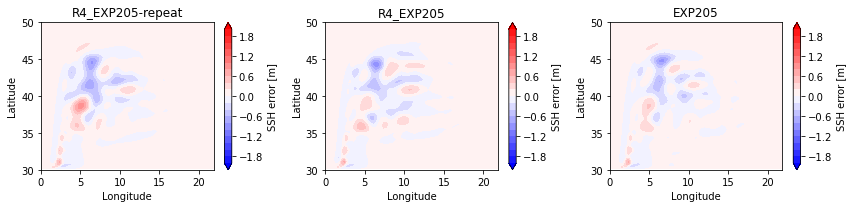

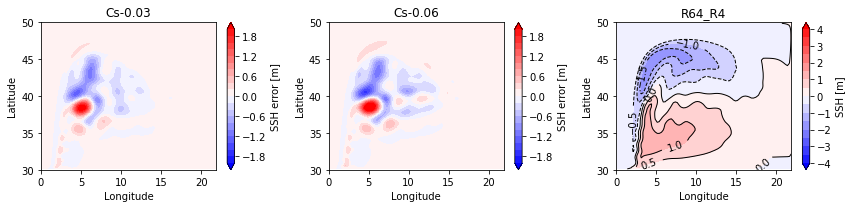

In [47]:
ds.plot_ssh(['R4_EXP205-repeat', 'R4_EXP205', 'EXP205'], target='R64_R4')
ds.plot_ssh(['Cs-0.03', 'Cs-0.06', 'R64_R4'], target='R64_R4')

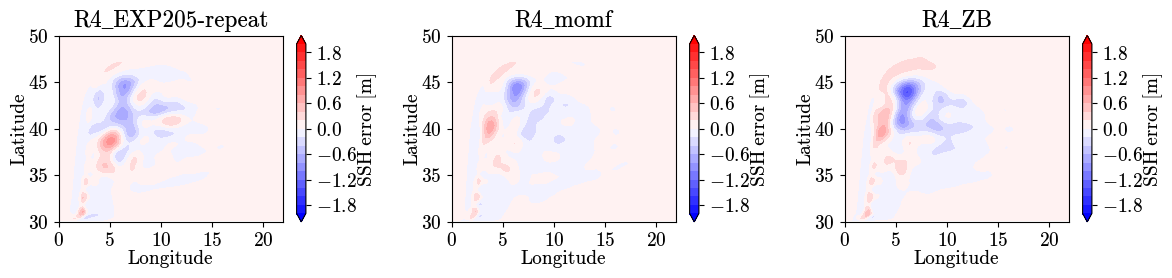

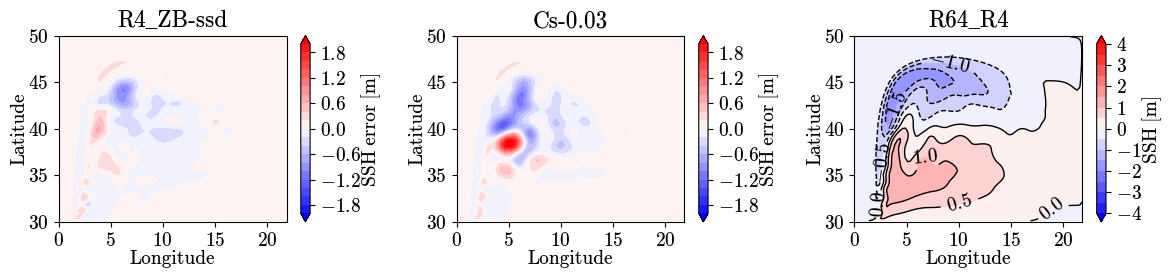

In [61]:
ds.plot_ssh(['R4_EXP205-repeat', 'R4_momf', 'R4_ZB'], target='R64_R4')
ds.plot_ssh(['R4_ZB-ssd', 'Cs-0.03', 'R64_R4'], target='R64_R4')

In [50]:
Lk_error(ds['R4_EXP205-repeat'].ssh_mean, ds['R64_R4'].ssh_mean)

[0.1380232]

In [51]:
Lk_error(ds['R4_EXP205'].ssh_mean, ds['R64_R4'].ssh_mean)

[0.11876867]

In [52]:
Lk_error(ds['EXP205'].ssh_mean, ds['R64_R4'].ssh_mean)

[0.11194565]

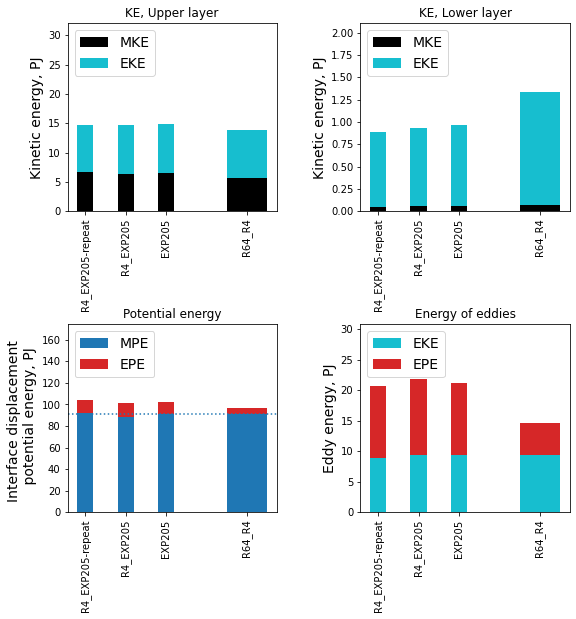

In [53]:
ds.plot_KE_PE(['R4_EXP205-repeat', 'R4_EXP205', 'EXP205', 'R64_R4'])

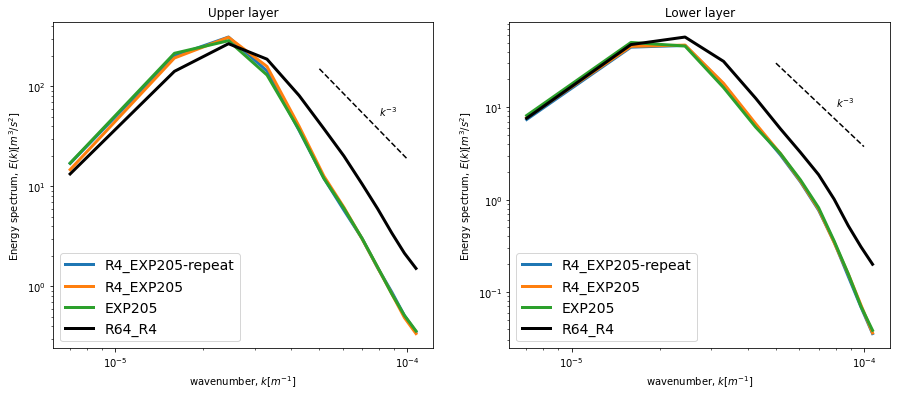

In [54]:
ds.plot_KE_spectrum(['R4_EXP205-repeat', 'R4_EXP205', 'EXP205', 'R64_R4'])

Text(0.5, 1.1, 'Online transfer and power spectrum for upper layer')

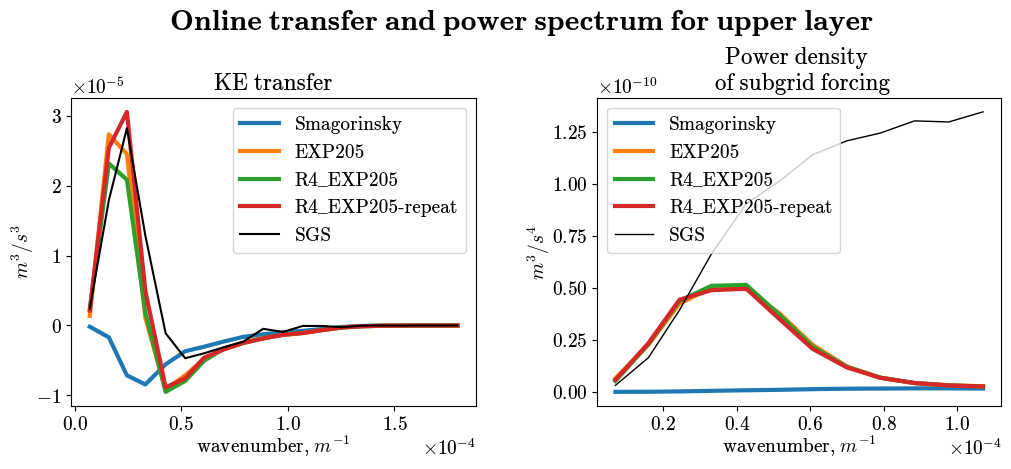

In [57]:
default_rcParams()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ds['Cs-0.03'].Model_transfer.isel(zl=0).plot(label='Smagorinsky', lw=3)
ds['EXP205'].Model_transfer.isel(zl=0).plot(label='EXP205', lw=3)
ds['R4_EXP205'].Model_transfer.isel(zl=0).plot(label='R4_EXP205', lw=3)
ds['R4_EXP205-repeat'].Model_transfer.isel(zl=0).plot(label='R4_EXP205-repeat', lw=3)
ds['R64_R4'].SGS_transfer.isel(zl=0).plot(color='k', label='SGS')
plt.legend()
plt.xlabel('wavenumber, $m^{-1}$')
plt.title('KE transfer')
plt.ylabel('$m^3/s^3$')

plt.subplot(1,2,2)
ds['Cs-0.03'].Model_power.isel(zl=0).plot(label='Smagorinsky', lw=3)
ds['EXP205'].Model_power.isel(zl=0).plot(label='EXP205', lw=3)
ds['R4_EXP205'].Model_power.isel(zl=0).plot(label='R4_EXP205', lw=3)
ds['R4_EXP205-repeat'].Model_power.isel(zl=0).plot(label='R4_EXP205-repeat', lw=3)
ds['R64_R4'].SGS_power.isel(zl=0).plot(color='k', label='SGS', lw=1)
plt.legend()
plt.xlabel('wavenumber, $m^{-1}$')
plt.title('Power density \n of subgrid forcing')
plt.ylabel('$m^3/s^4$')
plt.suptitle('Online transfer and power spectrum for upper layer', y=1.1, fontsize=20, fontweight='bold')